# Construct knowledge graph

## Download relevant files and databases

Most of the datasets are open source to the public although you must register for a (free) UMLS license to download the whole UMLS database and create a (free) account to download the full LOINC database. 

- UMLS Metathesaurus Full Subset: https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html (version `2024AB`)
- SNOMET CT US: https://www.nlm.nih.gov/healthit/snomedct/us_edition.html 
- CORE Problem List Subset of SNOMED CT: https://www.nlm.nih.gov/research/umls/Snomed/core_subset.html (version `SNOMEDCT_CORE_SUBSET_202411`)
- Kaiser Permanente Problem List Subset: https://download.nlm.nih.gov/mlb/utsauth/CMT/2024/UMLS_KP_ProblemList_Mapping_20240930.txt (requires UMLS login) 
- LOINC: https://loinc.org/downloads/ (version `2.76`)
- RxNorm: https://www.nlm.nih.gov/research/umls/rxnorm/docs/rxnormfiles.html (version `RxNorm_full_04012024`)
- PheMap: https://www.vumc.org/cpm/phemap (see 'PheMap Knowledgebase Downloads')
- Phecode Map: https://phewascatalog.org/phewas/#phe12 (`Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv`)
- General Equivalence Mapping: https://www.cms.gov/medicare/coding-billing/icd-10-codes/icd-10-cm-icd-10-pcs-gem-archive (version `FY20`)

In [1]:
import pandas as pd
import duckdb
import networkx as nx

We tried to avoid doing any pre-processing of the files outside of the main script, but due to non-ascii characters and correctly escaping quote marks listed in terms' definitions. 

Specifically, we filter the concepts file (MRCONSO.RRF) by all English concepts. For the concept atom file ('MRSAT.RRF'), we omit the last column which provides text desciptions of how each atom is assigned. This information is not used in the construction of the KG. 

In [ ]:
awk -F'|' '$2 == "ENG"' MRCONSO.RRF > MRCONSO.ENG.RRF

## Nodes

The files are very large (9+GB). We recommend using duckdb which allows database style querying. Previous attempts at using pandas and polars resulted in memory errors.

In [2]:
concept_duckfile=duckdb.read_csv("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/data/2024AB/META/MRCONSO.ENG.RRF",
                          sep='|', header=False)
# ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF']

### ICD10-CM

In [3]:
icd10_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'ICD10CM'
    AND f.column16 != 'O'
    """
    ).df()
icd10_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
# Concepts that map to ranges of ICD10CM codes are often too broad and are omitted
icd10_concept_df = icd10_concept_df.loc[~icd10_concept_df['CODE'].str.contains('-')]

# only keep codes with 6 or less characters (two places after decimal point)
icd10_concept_df = icd10_concept_df.assign(len_icd=icd10_concept_df['CODE'].apply(lambda x: len(x)))
icd10_concept_df = icd10_concept_df.loc[icd10_concept_df['len_icd'] <= 6+1] # 7 bc of decimal points

n = len(icd10_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd10_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd10_concept_df.head()

Number of rows in ICD10CM concept df: 77657
Number of CUI in ICD10CM concept df: 49369
Number of codes in ICD10CM concept df: 41407


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x,len_icd
0,C0000727,ENG,P,L0000727,VCW,S0584932,N,A17803269,None,None,R10.0,ICD10CM,PT,R10.0,Acute abdomen,4,N,256.0,None,5
1,C0000727,ENG,P,L0000727,VCW,S0584932,N,A20117915,None,None,R10.0,ICD10CM,AB,R10.0,Acute abdomen,4,Y,256.0,None,5
2,C0000744,ENG,P,L0000744,PF,S0009088,N,A17774174,None,None,E78.6,ICD10CM,ET,E78.6,Abetalipoproteinemia,4,N,256.0,None,5
3,C0000770,ENG,P,L0000770,PF,S0218356,N,A17826655,None,None,K00.2,ICD10CM,PT,K00.2,Abnormalities of size and form of teeth,4,N,NaN,None,5
4,C0000770,ENG,P,L0000770,PF,S0218356,N,A20107438,None,None,K00.2,ICD10CM,AB,K00.2,Abnormalities of size and form of teeth,4,Y,NaN,None,5


### ICD9CM

In [5]:
icd9_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'ICD9CM'
    AND f.column16 != 'O'
    """
    ).df()
icd9_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
# Concepts that map to ranges of ICD10CM codes are often too broad and are omitted
icd9_concept_df = icd9_concept_df.loc[~icd9_concept_df['CODE'].str.contains('-')]

# remove ICDs < 1 (procedures)
icd9_concept_df = icd9_concept_df.loc[~icd9_concept_df['CODE'].str.startswith('00.')]

n = len(icd9_concept_df)
print("Number of rows in ICD10CM concept df: %d" % n)

n = len(icd9_concept_df['CUI'].unique())
print("Number of CUI in ICD10CM concept df: %d" % n)

n = len(icd9_concept_df['CODE'].unique())
print("Number of codes in ICD10CM concept df: %d" % n)

icd9_concept_df.head()

Number of rows in ICD10CM concept df: 17836
Number of CUI in ICD10CM concept df: 15463
Number of codes in ICD10CM concept df: 15911


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
0,C0000737,ENG,P,L0000737,VC,S0353662,N,A8352146,None,None,789.0,ICD9CM,HT,789.0,Abdominal pain,0,N,256.0,None
1,C0000770,ENG,P,L0000770,PF,S0218356,N,A8341389,None,None,520.2,ICD9CM,PT,520.2,Abnormalities of size and form of teeth,0,N,NaN,None
2,C0000774,ENG,P,L0000774,PF,S0217822,N,A8340917,None,None,251.5,ICD9CM,PT,251.5,Abnormality of secretion of gastrin,0,N,256.0,None
3,C0000786,ENG,P,L0000819,PF,S0218600,N,A8341632,None,None,634,ICD9CM,HT,634,Spontaneous abortion,0,N,256.0,None
4,C0000814,ENG,P,L0000814,PF,S0218595,N,A16978587,None,None,632,ICD9CM,AB,632,Missed abortion,0,Y,256.0,None


### ATC

In [7]:
# ATC
atc_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'ATC'
    AND f.column16 != 'O'
    """
    ).df()
atc_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
# only keep ATC4 and ATC5
atc_concept_df = atc_concept_df.assign(len_atc=atc_concept_df['CODE'].apply(len))
atc_concept_df = atc_concept_df.loc[atc_concept_df['len_atc'] >= 4]

n = len(atc_concept_df)
print("Number of rows in ATC concept df: %d" % n)

n = len(atc_concept_df['CUI'].unique())
print("Number of CUI in ATC concept df: %d" % n)

n = len(atc_concept_df['CODE'].unique())
print("Number of codes in ATC concept df: %d" % n)

atc_concept_df.head()

Number of rows in ATC concept df: 6064
Number of CUI in ATC concept df: 5400
Number of codes in ATC concept df: 6063


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x,len_atc
0,C0000294,ENG,P,L0025479,PF,S0525354,N,A22725806,None,None,None,ATC,IN,V03AF01,mesna,0,N,256.0,None,7
1,C0000294,ENG,P,L0025479,PF,S0525354,N,A22730790,None,None,None,ATC,IN,R05CB05,mesna,0,N,256.0,None,7
2,C0000378,ENG,P,L0565039,PF,S14426412,N,A26457020,None,None,None,ATC,IN,C01CA27,droxidopa,0,N,256.0,None,7
3,C0000402,ENG,P,L0400547,VC,S13956572,Y,A22722399,None,None,None,ATC,IN,C10AX05,meglutol,0,N,256.0,None,7
4,C0000618,ENG,P,L0025406,PF,S0525333,N,A22722081,None,None,None,ATC,IN,L01BB02,mercaptopurine,0,N,256.0,None,7


### LOINC

In [9]:
# LNC
lnc_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'LNC'
    AND f.column16 != 'O'
    """
    ).df()

lnc_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
loinc_part_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Loinc_2.76/AccessoryFiles/PartFile/Part.csv")
loinc_part_df = loinc_part_df.loc[loinc_part_df['Status'] == 'ACTIVE']

n = len(loinc_part_df)
print("Number of LOINC parts before filtering by part name: %d" % n)

loinc_part_df = loinc_part_df.loc[~loinc_part_df['PartTypeName'].isin(['ADJUSTMENT', 'CHALLENGE', 'COUNT', 'PROPERTY', 'SCALE', 'SUPER SYSTEM', 'TIME', 'TIME MODIFIER'])]

n = len(loinc_part_df)
print("Number of LOINC parts after filtering: %d" % n)

# filter concept df by loinc part numbers
lnc_concept_df = lnc_concept_df.loc[lnc_concept_df['CODE'].isin(loinc_part_df['PartNumber'])]
n = len(lnc_concept_df)
print("Number of rows in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CUI'].unique())
print("Number of CUI in LOINC concept df: %d" % n)

n = len(lnc_concept_df['CODE'].unique())
print("Number of codes in LOINC concept df: %d" % n)

lnc_concept_df.head()

Number of LOINC parts before filtering by part name: 69958
Number of LOINC parts after filtering: 67853
Number of rows in LOINC concept df: 106077
Number of CUI in LOINC concept df: 58326
Number of codes in LOINC concept df: 59614


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
0,C0000052,ENG,P,L0000052,VC,S10031008,N,A18243499,None,LP15278-2,None,LNC,LPN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN,None
1,C0000052,ENG,P,L0000052,VC,S10031008,N,A32930458,None,LP15278-2,None,LNC,LPDN,LP15278-2,"1,4-Alpha glucan branching enzyme",0,N,NaN,None
3,C0000163,ENG,P,L0000163,PF,S0007806,N,A18359748,None,LP15290-7,None,LNC,LPN,LP15290-7,17-Hydroxycorticosteroids,0,N,256.0,None
5,C0000163,ENG,P,L0000163,PF,S0007806,N,A32789945,None,LP15290-7,None,LNC,LPDN,LP15290-7,17-Hydroxycorticosteroids,0,N,256.0,None
6,C0000167,ENG,P,L0000167,PF,S0007811,N,A18243505,None,LP17185-7,None,LNC,LPN,LP17185-7,17-Ketosteroids,0,N,256.0,None


### CPT

In [11]:
# CPT
cpt_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'CPT'
    AND f.column16 != 'O'
    """
    ).df()

cpt_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
# category I only: 00100–99499
cpt_concept_df = cpt_concept_df.assign(CODE_INT=[int(x) if x.isnumeric() else -999 for x in cpt_concept_df['CODE'].tolist()])
cpt_concept_df = cpt_concept_df.loc[cpt_concept_df['CODE_INT'].between(100,99499)]

# There are many CUIs mapped to individual CPT codes due to many detailed atoms
# To reduce excessive redundancies, we limit to only the preferred term ('PT')
cpt_concept_df = cpt_concept_df.loc[cpt_concept_df['TTY'] == 'PT']
n = len(cpt_concept_df)
print("Number of rows in CPT concept df: %d" % n)

n = len(cpt_concept_df['CUI'].unique())
print("Number of CUI in CPT concept df: %d" % n)

n = len(cpt_concept_df['CODE'].unique())
print("Number of codes in CPT concept df: %d" % n)

cpt_concept_df.head()

Number of rows in CPT concept df: 8016
Number of CUI in CPT concept df: 8016
Number of codes in CPT concept df: 8016


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x,CODE_INT
5,C0002692,ENG,P,L0226771,VO,S0589056,Y,A0644164,None,27880,None,CPT,PT,27880,"Amputation, leg, through tibia and fibula",3,N,NaN,None,27880
8,C0003611,ENG,P,L0003611,PF,S0015390,N,A0025784,None,44950,None,CPT,PT,44950,Appendectomy,3,N,256.0,None,44950
13,C0003612,ENG,P,L0003612,PF,S0005560,N,A0013911,None,44960,None,CPT,PT,44960,Appendectomy; for ruptured appendix with absce...,3,N,NaN,None,44960
22,C0008322,ENG,P,L0008322,VO,S0005570,Y,A0013917,None,47612,None,CPT,PT,47612,Cholecystectomy with exploration of common duc...,3,N,NaN,None,47612
24,C0008323,ENG,P,L0008323,PF,S0005571,N,A0013918,None,47620,None,CPT,PT,47620,Cholecystectomy with exploration of common duc...,3,N,NaN,None,47620


### SNOMED

In [13]:
# SNOMED
snomed_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'SNOMEDCT_US'
    AND f.column16 != 'O'
    """
    ).df()

snomed_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# we limit inclusion to only the core subset of SNOMEDCT codes at this step (original set has 350K+ codes)
core_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/SNOMEDCT_CORE_SUBSET_202411/SNOMEDCT_CORE_SUBSET_202411.txt", sep='|')
core_df = core_df.loc[core_df['SNOMED_CONCEPT_STATUS'] == 'Current']
core_df = core_df.assign(SNOMED_CID=core_df['SNOMED_CID'].astype(str))

# KP list 
kp_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/UMLS_KP_ProblemList_Mapping_20240930.txt", sep='\t', encoding='latin-1')
#https://download.nlm.nih.gov/mlb/utsauth/CMT/2024/UMLS_KP_ProblemList_Mapping_20240930.txt?_gl=1*th37o*_ga*MTUwNzQ1MzA5MC4xNjkzOTQwNzAy*_ga_7147EPK006*MTc0MzM2NTgzOS4xOTIuMS4xNzQzMzY2NzU0LjAuMC4w*_ga_P1FPTH9PL4*MTc0MzM2NTgzOS4xOTMuMS4xNzQzMzY2NzU0LjAuMC4w
kp_df['SCTID'] = kp_df['SCTID'].astype(str)

snomed_concept_df = snomed_concept_df.loc[snomed_concept_df['CODE'].isin(core_df['SNOMED_CID'].tolist() + kp_df['SCTID'].tolist())]

n = len(snomed_concept_df)
print("Number of rows in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CUI'].unique())
print("Number of CUI in SNOMEDCT concept df: %d" % n)

n = len(snomed_concept_df['CODE'].unique())
print("Number of codes in SNOMEDCT concept df: %d" % n)

snomed_concept_df.head()

Number of rows in SNOMEDCT concept df: 37139
Number of CUI in SNOMEDCT concept df: 31570
Number of codes in SNOMEDCT concept df: 31251


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
39,C0000727,ENG,P,L0000727,VCW,S0584932,Y,A2988568,16183017,9209005,None,SNOMEDCT_US,PT,9209005,Acute abdomen,9,N,256.0,None
40,C0000731,ENG,P,L0486265,PF,S0582832,N,A2987242,498835017,60728008,None,SNOMEDCT_US,SY,60728008,Abdomen distended,9,N,2304.0,None
41,C0000734,ENG,P,L0000734,PF,S0582855,N,A2987267,406851019,271860004,None,SNOMEDCT_US,PT,271860004,Abdominal mass,9,N,2304.0,None
42,C0000737,ENG,P,L0000737,VC,S0353662,Y,A2921922,36112013,21522001,None,SNOMEDCT_US,PT,21522001,Abdominal pain,9,N,2304.0,None
44,C0000744,ENG,P,L0000744,PF,S0009088,N,A2877994,293311018,190787008,None,SNOMEDCT_US,PT,190787008,Abetalipoproteinemia,9,N,256.0,None


### RXNORM

In [15]:
rxnorm_concept_df = duckdb.sql(
    f"""
    SELECT 
        f.*,
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 = 'RXNORM'
    AND f.column16 != 'O'
    """
    ).df()

rxnorm_concept_df.columns = ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE','STR', 'SRL', 'SUPPRESS', 'CVF', 'x']

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [16]:
prescribe_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/RxNorm_full_04012024/prescribe/rrf/RXNCONSO.RRF", sep='|', header=None)
prescribe_df[0] = prescribe_df[0].astype(str)

rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['CODE'].isin(prescribe_df[0].tolist())]

# limit to term types: ingredient, particular ingredient, multiple ingredient, Semantic clinical drug and form, Semantic clinical drug group with precise ingredient as basis of strength
rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['TTY'].isin(['IN', 'PIN', 'MIN', 'SCDG', 'SCDGP'])] 

n = len(rxnorm_concept_df)
print("Number of rows in RXNORM concept df: %d" % n)

n = len(rxnorm_concept_df['CUI'].unique())
print("Number of CUI in RXNORM concept df: %d" % n)

n = len(rxnorm_concept_df['CODE'].unique())
print("Number of codes in RXNORM concept df: %d" % n)

rxnorm_concept_df.head()

Number of rows in RXNORM concept df: 16979
Number of CUI in RXNORM concept df: 16979
Number of codes in RXNORM concept df: 16979


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,x
2,C0000294,ENG,P,L0025479,PF,S0525354,N,A31762929,12251526,44,None,RXNORM,IN,44,mesna,0,N,4352.0,None
3,C0000378,ENG,P,L0565039,PF,S14426412,N,A31685600,12254325,1489913,None,RXNORM,IN,1489913,droxidopa,0,N,4352.0,None
4,C0000392,ENG,P,L0005188,PF,S11855837,N,A31642632,12254378,61,None,RXNORM,IN,61,beta-alanine,0,N,4352.0,None
5,C0000464,ENG,P,L0012967,PF,S19607957,N,A31643165,12252051,73,None,RXNORM,IN,73,docosahexaenoate,0,N,4352.0,None
6,C0000473,ENG,P,L0000473,PF,S1424701,N,A31643235,12253228,74,None,RXNORM,IN,74,4-aminobenzoic acid,0,N,4352.0,None


### ATOMS from PheMap CUI's
Source codes for core CUI codes listed in PheMap

In [19]:
# limit cui to those in phemap
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
core_cui_list = phemap_cui_df['CUI'].tolist()

In [20]:
atom_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 IN {['ATC', 'ICD10CM', 'ICD9CM', 'CPT', 'RXNORM', 'SNOMEDCT_US', 'LNC']}
    AND f.column16 != 'O'
    """
    ).df()
atom_df.columns = ['CUI', 'SAB', 'CODE', 'STR']

atom_df = atom_df.loc[atom_df['CUI'].isin(core_cui_list)]

# filtering to prevent loinc-answers
atom_df = atom_df.loc[(atom_df['SAB'] == 'LNC') & (atom_df['CODE'].str.startswith('LP')) | (atom_df['SAB'] != 'LNC')]
atom_df[['SAB', 'CODE']].drop_duplicates().groupby('SAB').count()

atom_df.to_csv("atom_df.csv", sep='|', index=False)

print(atom_df.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(36670, 4)


### Phecodes

In [18]:
phecode_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv")
phecode_map_df = phecode_map_df.assign(Phecode=phecode_map_df['Phecode'].astype(str))

phecode_concept_df = phecode_map_df[['Phecode', 'PhecodeString']].drop_duplicates()
phecode_concept_df.columns = ['node_id', 'node_name']
phecode_concept_df['ntype'] = 'PHECODE'
phecode_concept_df['node_id'] = phecode_concept_df['node_id'] + ':phecode'
phecode_concept_df.head(2)

,node_id,node_name,ntype
0,8.0:phecode,Intestinal infection,PHECODE
5,8.5:phecode,Bacterial enteritis,PHECODE


### Core CUI

In [21]:
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
core_cui_list = phemap_cui_df['CUI'].tolist()

core_cui_list = list(set(core_cui_list))

cui_concept_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    --WHERE f.column02 = 'P'
    --AND f.column16 != 'O'
    """
    ).df()

cui_concept_df.columns = ['CUI', 'SAB', 'CODE', 'STR']
cui_concept_df = cui_concept_df.loc[cui_concept_df['CUI'].isin(core_cui_list)].drop_duplicates('CUI', keep='first')
cui_concept_df = cui_concept_df.drop(['SAB', 'CODE'], axis=1)
cui_concept_df.columns = ['node_id', 'node_name']
cui_concept_df['ntype'] = 'UMLS_CUI'
cui_concept_df['node_id'] = cui_concept_df['node_id'] + ':umls_cui'
cui_concept_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(42883, 3)

### Extra node filtering

In [22]:
# limit ICD10 codes that have a phecode
print("Before filtering: %d" % len(icd10_concept_df))

icd10_concept_df = icd10_concept_df.loc[(icd10_concept_df['CODE'].isin(phecode_map_df.loc[phecode_map_df['Flag'] == 10]['ICD'].tolist()))]

print("After filtering: %d" % len(icd10_concept_df))

Before filtering: 77657
After filtering: 65662


In [23]:
# limit ICD9 codes that have a phecode
print("Before filtering: %d" % len(icd9_concept_df))

icd9_concept_df = icd9_concept_df.loc[(icd9_concept_df['CODE'].isin(phecode_map_df.loc[phecode_map_df['Flag'] == 9]['ICD'].tolist()))]

print("After filtering: %d" % len(icd9_concept_df))

Before filtering: 17836
After filtering: 11463


In [25]:
# filter rxnorm to those connected to atc ingredient (plus rxnorm filters)
print("Before filtering rxnorm: %d" % len(rxnorm_concept_df))
atcprod_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/atc_prod.csv")
atcprod_df = atcprod_df.loc[atcprod_df['atc_prod'] != 'XXXX']
atcprod_df.columns = ['column00', 'column04']
atcprod_df['column07'] = 'atc_prod'
atcprod_df['column00'] = atcprod_df['column00'].astype(str)
atcprod_df = atcprod_df.loc[atcprod_df['column00'].isin(rxnorm_concept_df['CODE']) & 
                      atcprod_df['column04'].isin(atc_concept_df['CODE'])]

rxnorm_concept_df = rxnorm_concept_df.loc[rxnorm_concept_df['CODE'].isin(atcprod_df['column00'])]

print("After filtering rxnorm: %d" % len(rxnorm_concept_df))


Before filtering rxnorm: 16979
After filtering rxnorm: 9881


### Assemble all nodes

In [26]:
# start with source code from core cui codes
atom_df = pd.read_csv("atom_df.csv", sep='|')
atom_df['node_id'] = atom_df['CODE'] + ':' + atom_df['SAB'].str.lower()
atom_df['node_name'] = atom_df['STR'].copy()
atom_df['ntype'] =  atom_df['SAB'].copy()
atom_df = atom_df[['node_id', 'node_name', 'ntype']]

In [27]:
# nodes pulled by SAB
all_concept_df = pd.concat([icd9_concept_df, icd10_concept_df, atc_concept_df, rxnorm_concept_df, 
                            lnc_concept_df, cpt_concept_df, snomed_concept_df])[['CODE', 'SAB', 'STR', 'CUI']]
all_concept_df.columns = ['node_id', 'ntype', 'node_name', 'CUI']
all_concept_df['node_id'] = all_concept_df['node_id'] + ':' + all_concept_df['ntype'].str.lower() 
all_concept_df.head()

,node_id,ntype,node_name,CUI
0,789.0:icd9cm,ICD9CM,Abdominal pain,C0000737
1,520.2:icd9cm,ICD9CM,Abnormalities of size and form of teeth,C0000770
2,251.5:icd9cm,ICD9CM,Abnormality of secretion of gastrin,C0000774
3,634:icd9cm,ICD9CM,Spontaneous abortion,C0000786
4,632:icd9cm,ICD9CM,Missed abortion,C0000814


In [28]:
# SAB nodes, src nodes from core-cui atoms, phecodes, core cui
node_df = pd.concat([all_concept_df, atom_df, phecode_concept_df, cui_concept_df])[['node_id', 'node_name', 'ntype']].drop_duplicates(['node_id'])

print("Total number of nodes: %d" % node_df.shape[0])

# keep old node-id for constructing edges
all_concept_df['old_node_id'] = all_concept_df['node_id'].str.split(':', expand=True)[0]

Total number of nodes: 223624


In [29]:
node_df.to_csv("node_v3_df.csv", sep='\t', index=False)

In [30]:
# node type counts
node_df.groupby('ntype').count()

,node_id,node_name
ntype,,
ATC,6080,6080
CPT,8233,8233
ICD10CM,34958,34958
ICD9CM,10420,10420
LNC,59872,59872
PHECODE,1873,1873
RXNORM,10890,10890
SNOMEDCT_US,48415,48415
UMLS_CUI,42883,42883


## Edges

In [31]:
rel_duckfile=duckdb.read_csv("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/data/2024AB/META/MRREL.RRF",
                          sep='|', header=False)

### Get RXPROD ingredients (ATC4-RxNorm)

In [39]:
import requests
import json
from tqdm.notebook import tqdm

#rx_list = atom_df.loc[atom_df['SAB'] == 'RXNORM']['CODE'].unique()
#len(rx_list)

In [40]:
#atcprod_list = []

#for rxcui in tqdm(rx_list): 
#    url="https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?rxcui={}&relaSource=ATCPROD".format(rxcui)
#    response = requests.get(url)

#    if response.status_code == 200:
#        obj = json.loads(response.text)

#        if len(obj.keys()) > 0:
#            atc_id = obj['rxclassDrugInfoList']['rxclassDrugInfo'][0]['rxclassMinConceptItem']['classId']
#        else:
#            atc_id = 'XXXX'
            #print(rxcui)
#    else:
#        atc_id = 'XXXX'
        #print(rxcui)
        
#    atcprod_list.append(atc_id)
#atcprod_df = pd.DataFrame({'rxcui': rx_list, 'atc_prod': atcprod_list})
#atcprod_df.to_csv("atc_prod.csv", sep=',', index=False)

In [32]:
atcprod_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/atc_prod.csv")
atcprod_df = atcprod_df.loc[atcprod_df['atc_prod'] != 'XXXX']
atcprod_df.columns = ['column00', 'column04']
atcprod_df['column07'] = 'atc_prod'
atcprod_df['column00'] = atcprod_df['column00'].astype(str)

atcprod_df = atcprod_df.loc[atcprod_df['column00'].isin(rxnorm_concept_df['CODE']) & 
                      atcprod_df['column04'].isin(atc_concept_df['CODE'])]

atcprod_df = atcprod_df.merge(rxnorm_concept_df[['CODE', 'STR']], left_on='column00', right_on='CODE').drop(['CODE'], axis=1)
atcprod_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'node_name_x']
atcprod_df = atcprod_df.merge(atc_concept_df[['CODE', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)

atcprod_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'node_name_x', 'node_name_y']
atcprod_df['node_id_x'] = atcprod_df['node_id_x'] + ':' + 'rxnorm'
atcprod_df['node_id_y'] = atcprod_df['node_id_y'] + ':' + 'atc'

atcprod_df['ntype_x'] = 'RXNORM'
atcprod_df['ntype_y'] = 'ATC'

### ATC5/RXNORM/LNC - RXNORM (ingredient-level) 

In [33]:
atc_ingred_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['RXNORM']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [34]:
atc_ingred_df = atc_ingred_df.loc[atc_ingred_df['column00'].isin(all_concept_df['CUI']) & 
                      atc_ingred_df['column04'].isin(all_concept_df['CUI'])]

atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship']
atc_ingred_df = atc_ingred_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
atc_ingred_df = atc_ingred_df.drop(['CUI'],axis=1)


atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

atc_ingred_df = atc_ingred_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

atc_ingred_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
atc_ingred_df = atc_ingred_df.loc[atc_ingred_df['CODE_1'] != atc_ingred_df['CODE_2']].drop_duplicates()

atc_ingred_df = atc_ingred_df.loc[(atc_ingred_df['relationship']=='ingredient_of')]
atc_ingred_df = atc_ingred_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

atc_ingred_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

### MED-RT cui-cui

In [35]:
medrt_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column07 IN {['may_prevent', 'may_treat', 'may_be_treated_by', 'may_be_prevented_by']}
    AND f.column11 = 'MED-RT'
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
medrt_relation_df = medrt_relation_df.loc[medrt_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      medrt_relation_df['column04'].isin(all_concept_df['CUI'])]

# add back source nodes from cui
medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
medrt_relation_df = medrt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
medrt_relation_df = medrt_relation_df.drop(['CUI'],axis=1)


medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']
medrt_relation_df = medrt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)
medrt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
medrt_relation_df = medrt_relation_df.loc[medrt_relation_df['CODE_1'] != medrt_relation_df['CODE_2']].drop_duplicates()

medrt_relation_df = medrt_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]
medrt_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
medrt_relation_df.shape

(83996, 7)

### ATC - ATC/RXNORM 'member-of'/'is-a'

In [37]:
atc_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['ATC']
    """
).df()
atc_relation_df = atc_relation_df.loc[atc_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      atc_relation_df['column04'].isin(all_concept_df['CUI'])]

atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
atc_relation_df = atc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
atc_relation_df = atc_relation_df.drop(['CUI'],axis=1)


atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

atc_relation_df = atc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

atc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
atc_relation_df = atc_relation_df.loc[atc_relation_df['CODE_1'] != atc_relation_df['CODE_2']].drop_duplicates()

atc_relation_df = atc_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

atc_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
atc_relation_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(24338, 7)

### RXNORM 'ingredient'/'form-of'

In [39]:
rxnorm_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['RXNORM']
    """
).df()
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      rxnorm_relation_df['column04'].isin(all_concept_df['CUI'])]

rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
rxnorm_relation_df = rxnorm_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
rxnorm_relation_df = rxnorm_relation_df.drop(['CUI'],axis=1)


rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

rxnorm_relation_df = rxnorm_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

rxnorm_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['CODE_1'] != rxnorm_relation_df['CODE_2']].drop_duplicates()

rxnorm_relation_df = rxnorm_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

rxnorm_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']
rxnorm_relation_list = ['has_part', 'has_ingredient', 'has_form', 'part_of', 'ingredient_of', 'form_of']
rxnorm_relation_df = rxnorm_relation_df.loc[rxnorm_relation_df['relationship'].isin(rxnorm_relation_list)]

rxnorm_relation_df.head()
rxnorm_relation_df.shape

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(62014, 7)

### CPT 'assoc-proc'/'site-of-proc'

In [40]:
cpt_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['CPT']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [41]:
cpt_relation_df = cpt_relation_df.loc[cpt_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      cpt_relation_df['column04'].isin(all_concept_df['CUI'])]

cpt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
cpt_relation_df = cpt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
cpt_relation_df = cpt_relation_df.drop(['CUI'],axis=1)


cpt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

cpt_relation_df = cpt_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

cpt_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
cpt_relation_df = cpt_relation_df.loc[cpt_relation_df['CODE_1'] != cpt_relation_df['CODE_2']].drop_duplicates()

cpt_relation_df = cpt_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

cpt_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

keep_list = ['associated_procedure_of', 'has_associated_procedure', 'has_procedure_site', 'procedure_site_of', 'has_pathology', 'pathology_of', 'add_on_code_for', 'has_add_on_code']
cpt_relation_df = cpt_relation_df.loc[cpt_relation_df['relationship'].isin(keep_list)]
cpt_relation_df.shape

(28542, 7)

### LOINC (labs related to each other)

In [42]:
lnc_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['LNC']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [43]:
lnc_relation_df = lnc_relation_df.loc[lnc_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      lnc_relation_df['column04'].isin(all_concept_df['CUI'])]

lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
lnc_relation_df = lnc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
lnc_relation_df = lnc_relation_df.drop(['CUI'],axis=1)


lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

lnc_relation_df = lnc_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

lnc_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
lnc_relation_df = lnc_relation_df.loc[lnc_relation_df['CODE_1'] != lnc_relation_df['CODE_2']].drop_duplicates()

lnc_relation_df = lnc_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

lnc_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

### SNOMEDCT 'assoc-with'/'causes'/'other'

In [44]:
snomed_relation_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column04,
        f.column07
    FROM rel_duckfile as f
    WHERE f.column11 IN ['SNOMEDCT_US']
    """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [45]:
snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['column00'].isin(all_concept_df['CUI']) & 
                      snomed_relation_df['column04'].isin(all_concept_df['CUI'])]

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship']
snomed_relation_df = snomed_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_1', right_on='CUI')
snomed_relation_df = snomed_relation_df.drop(['CUI'],axis=1)

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1']

snomed_relation_df = snomed_relation_df.merge(all_concept_df[['CUI', 'node_id', 'node_name', 'ntype']], left_on='CUI_2', right_on='CUI').drop(['CUI'],axis=1)

snomed_relation_df.columns = ['CUI_1', 'CUI_2', 'relationship', 'CODE_1', 'STR_1', 'SAB_1', 'CODE_2', 'STR_2', 'SAB_2']
snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['CODE_1'] != snomed_relation_df['CODE_2']].drop_duplicates()

snomed_relation_df = snomed_relation_df[['CODE_1', 'STR_1', 'SAB_1', 'relationship', 'CODE_2', 'STR_2', 'SAB_2']]

snomed_relation_df.columns = ['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']

all_snomed_relation_df = snomed_relation_df.copy()
keep_list = ['cause_of', 'due_to', 'definitional_manifestation_of', 
             'has_definitional_manifestation', 'occurs_after', 'occurs_before', 'associated_with'] 
# 'has_associated_morphology', 'associated_morphology_of'

snomed_relation_df = snomed_relation_df.loc[snomed_relation_df['relationship'].isin(keep_list)]
snomed_relation_df.shape

(23708, 7)

In [66]:
# CPT: isa, inverse_isa
# ICD9CM: all
# ICD10CM: all
# ATC: all
# RXNORM: all (has_part, has_ingredient, has_form)
# LNC: all
# SNOMED: 'isa', 'inverse_isa', 'possibly_equivalent_to', 'partially_equivalent_to'

### PHECODE edges (ICD9/10-Phecode)

In [46]:
phecode_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/Phecode_map_v1_2_icd9_icd10cm_09_30_2024.csv")
phecode_map_df = phecode_map_df.assign(Phecode=phecode_map_df['Phecode'].astype(str))

phecode_icd9_df = phecode_map_df.loc[(phecode_map_df['Flag']==9) & (phecode_map_df['ICD'].isin(icd9_concept_df['CODE']))]
phecode_icd9_df = phecode_icd9_df[['ICD', 'ICDString', 'Phecode', 'PhecodeString']]
phecode_icd9_df.columns = ['node_id_x', 'node_name_x', 'node_id_y', 'node_name_y']

phecode_icd9_df['node_id_x'] = phecode_icd9_df['node_id_x'] + ':' + 'icd9cm'
phecode_icd9_df['node_id_y'] = phecode_icd9_df['node_id_y'] + ':' + 'phecode'

phecode_icd9_df['ntype_x'] = 'ICD9CM'
phecode_icd9_df['ntype_y'] = 'PHECODE'

phecode_icd10_df = phecode_map_df.loc[(phecode_map_df['Flag']==10) & (phecode_map_df['ICD'].isin(icd10_concept_df['CODE']))]
phecode_icd10_df = phecode_icd10_df[['ICD', 'ICDString', 'Phecode', 'PhecodeString']]
phecode_icd10_df.columns = ['node_id_x', 'node_name_x', 'node_id_y', 'node_name_y']

phecode_icd10_df['node_id_x'] = phecode_icd10_df['node_id_x'] + ':' + 'icd10cm'
phecode_icd10_df['node_id_y'] = phecode_icd10_df['node_id_y'] + ':' + 'phecode'

phecode_icd10_df['ntype_x'] = 'ICD10CM'
phecode_icd10_df['ntype_y'] = 'PHECODE'

### PheMap UMLS edges

In [47]:
phemap_cui_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/PheMap_UMLS_Concepts_1.1.csv")
phemap_cui_df = phemap_cui_df.assign(PHECODE=phemap_cui_df['PHECODE'].astype(str))
phecode_concept_df['new_node_id'] = phecode_concept_df['node_id'].str.split(':', expand=True)[0]
phemap_cui_df = phemap_cui_df.merge(phecode_concept_df, left_on='PHECODE', right_on='new_node_id').drop(['new_node_id', 'PHECODE', 'ntype', 'TFIDF'], axis=1)

phemap_cui_df.columns = ['node_id_x', 'node_id_y', 'node_name_y']
phemap_cui_df['ntype_y'] = 'PHECODE'
phemap_cui_df
cui_concept_df['new_node_id'] = cui_concept_df['node_id'].str.split(':', expand=True)[0]

phemap_cui_df = phemap_cui_df.merge(cui_concept_df, left_on='node_id_x', right_on='new_node_id').drop(['new_node_id', 'node_id'], axis=1)
phemap_cui_df.columns = ['node_id_x', 'node_id_y', 'node_name_y', 'ntype_y', 'node_name_x', 'ntype_x']

phemap_cui_df['node_id_y'] = phemap_cui_df['node_id_y'] 
phemap_cui_df['node_id_x'] = phemap_cui_df['node_id_x'] + ':' + 'umls_cui'

### Phemap expanded edges

In [48]:
cui_atom_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column02 = 'P'
    AND f.column11 IN {['ATC', 'ICD10CM', 'ICD9CM', 'CPT', 'RXNORM', 'SNOMEDCT_US', 'LNC']}
    AND f.column16 != 'O'
    """
    ).df()
cui_atom_df.columns = ['CUI', 'SAB', 'CODE', 'STR']

cui_atom_df = cui_atom_df.loc[cui_atom_df['CUI'].isin(core_cui_list)]

# filtering to prevent loinc-answers
cui_atom_df = cui_atom_df.loc[(cui_atom_df['SAB'] == 'LNC') & (cui_atom_df['CODE'].str.startswith('LP')) | (cui_atom_df['SAB'] != 'LNC')]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [49]:
cui_atom_df.columns = ['CUI', 'ntype', 'node_id', 'node_name']
cui_atom_df['node_id'] = cui_atom_df['node_id'] + ':' + cui_atom_df['ntype'].str.lower()

phemap_expand_df = phemap_cui_df.copy()

phemap_expand_df['CUI'] = phemap_expand_df['node_id_x'].str.split(':', expand=True)[0]
combo_concept_df = pd.concat([all_concept_df, cui_atom_df])

phemap_expand_df = combo_concept_df.merge(phemap_expand_df[['node_id_y', 'node_name_y', 'ntype_y', 'CUI']], on='CUI').drop(['CUI', 'old_node_id'], axis=1)
phemap_expand_df.columns = ['node_id_x', 'ntype_x', 'node_name_x', 'node_id_y', 'node_name_y', 'ntype_y']
phemap_expand_df = phemap_expand_df.drop_duplicates()

In [52]:
phemap_expand_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper_revision/PheMap_Mapped_Terminologies_1.1.csv")
phemap_expand_df = phemap_expand_df.assign(PHECODE=phemap_expand_df['PHECODE'].astype(str))

phemap_expand_df.columns = ['PHECODE', 'CODE', 'SAB', 'phemap_code_desc', 'TFIDF']
phemap_expand_df.head(2)
temp_df = phemap_expand_df.merge(all_concept_df[['ntype', 'old_node_id', 'node_name']], left_on=['SAB', 'CODE'], right_on=['ntype', 'old_node_id'])

obs_phemap_snomed = phemap_expand_df.loc[(~phemap_expand_df['CODE'].isin(temp_df['CODE']) )& (phemap_expand_df['SAB'] == 'SNOMEDCT_US')]['CODE'].tolist()
temp_df['STR'] = temp_df['node_name']

old_snomed_df = duckdb.sql(
    f"""
    SELECT 
        DISTINCT
        f.column00,
        f.column11,
        f.column13,
        f.column14
    FROM concept_duckfile as f
    WHERE f.column11 IN {['SNOMEDCT_US']}
    """
).df()


old_snomed_df = old_snomed_df.loc[old_snomed_df['column13'].isin(obs_phemap_snomed)][['column00', 'column11', 'column13']].drop_duplicates()

snomed_cui_dict = {}

for i, row in old_snomed_df.iterrows():
    cui = row['column00']
    snomed_code = row['column13']
    snomed_cui_dict[snomed_code] = cui
new_cui_snomed_dict = {}

for i, row in snomed_concept_df.iterrows():
    cui = row['CUI']
    code = row['CODE']
    new_cui_snomed_dict[cui] = code
    
obs_phemap_snomed_df = phemap_expand_df.loc[phemap_expand_df['CODE'].isin(obs_phemap_snomed)]
obs_phemap_snomed_df = obs_phemap_snomed_df.assign(CUI=[snomed_cui_dict[x] for x in obs_phemap_snomed_df['CODE'].tolist()])

obs_phemap_snomed_df = obs_phemap_snomed_df.assign(NEW_SNOMEDCT=obs_phemap_snomed_df['CUI'].map(new_cui_snomed_dict))
obs_phemap_snomed_df['CODE'] = obs_phemap_snomed_df['NEW_SNOMEDCT'].copy()

new_phemap_expand_df = pd.concat([temp_df.drop(['STR'], axis=1), obs_phemap_snomed_df.dropna().drop(['NEW_SNOMEDCT', 'CUI'], axis=1)])
new_phemap_expand_df.columns = ['node_id_x', 'CODE', 'SAB', 'node_name_x', 'x', 'ntype', 'old_node_id', 'node_id']
new_phemap_expand_df = new_phemap_expand_df.merge(all_concept_df[['ntype', 'old_node_id', 'node_name']], left_on=['SAB', 'CODE'], right_on=['ntype', 'old_node_id'])
new_phemap_expand_df = new_phemap_expand_df[['node_id_x', 'CODE', 'SAB', 'node_name_x']]
new_phemap_expand_df.columns = ['node_id_x', 'node_id_y', 'ntype_y', 'node_name_y']

new_phemap_expand_df['ntype_x'] = 'PHECODE'
new_phemap_expand_df['node_id_x'] = new_phemap_expand_df['node_id_x'] + ':' + new_phemap_expand_df['ntype_x'].str.lower()
new_phemap_expand_df['node_id_y'] = new_phemap_expand_df['node_id_y'] + ':' + new_phemap_expand_df['ntype_y'].str.lower()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### ICD9-ICD10 GEM edges

In [54]:
gem_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/icd10cmtoicd9gem.csv")
gem_df = gem_df.assign(icd10cm_len=gem_df['icd10cm'].apply(lambda x: len(x)))
keep_gem_df = gem_df.loc[(gem_df['no_map'] != 1)]
keep_gem_df = keep_gem_df.assign(icd10cm=keep_gem_df['icd10cm'].str.slice(0,3) + '.' + keep_gem_df['icd10cm'].str.slice(3,10))
keep_gem_df = keep_gem_df.assign(icd9cm=keep_gem_df['icd9cm'].str.slice(0,3) + '.' + keep_gem_df['icd9cm'].str.slice(3,10))

keep_gem_df = keep_gem_df[['icd10cm', 'icd9cm']]
keep_gem_df.columns = ['node_id_x', 'node_id_y']

keep_gem_df = keep_gem_df.merge(icd10_concept_df[['CODE', 'SAB', 'STR']], left_on='node_id_x', right_on='CODE').drop(['CODE'], axis=1)
keep_gem_df.columns = ['node_id_x', 'node_id_y', 'ntype_x', 'node_name_x']

keep_gem_df = keep_gem_df.merge(icd9_concept_df[['CODE', 'SAB', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)
keep_gem_df.columns = ['node_id_x', 'node_id_y', 'ntype_x', 'node_name_x', 'ntype_y', 'node_name_y']

keep_gem_df['node_id_y'] = keep_gem_df['node_id_y'] + ':' + keep_gem_df['ntype_y'].str.lower() 
keep_gem_df['node_id_x'] = keep_gem_df['node_id_x'] + ':' + keep_gem_df['ntype_x'].str.lower() 

### Atom edges (CUI-source_code)

In [55]:
atom_df = pd.read_csv("atom_df.csv", sep='|')
edge_atom_df = atom_df.copy()
edge_atom_df.columns = ['node_id_x', 'ntype_y', 'node_id_y', 'node_name_y']

edge_atom_df = edge_atom_df.merge(all_concept_df[['CUI', 'node_name']], left_on='node_id_x', right_on='CUI').drop(['CUI'], axis=1)
edge_atom_df.columns = ['node_id_x', 'ntype_y', 'node_id_y', 'node_name_y', 'node_name_x']

edge_atom_df['node_id_y'] = edge_atom_df['node_id_y'] + ':' + edge_atom_df['ntype_y'].str.lower()
edge_atom_df['ntype_x'] = 'UMLS_CUI'
edge_atom_df['node_id_x'] = edge_atom_df['node_id_x'] + ':' + edge_atom_df['ntype_x'].str.lower()

### SNOMED-ICD10CM edges

In [56]:
snomed_map_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/data/SnomedCT_ManagedServiceUS_PRODUCTION_US1000124_20240301T120000Z 2/Full/Refset/Map/der2_iisssccRefset_ExtendedMapFull_US1000124_20240301.txt", sep='\t')
snomed_map_df['referencedComponentId'] = snomed_map_df['referencedComponentId'].astype(str)
snomed_map_df['mapTarget'] = snomed_map_df['mapTarget'].astype(str)

snomed_map_df = snomed_map_df.loc[(snomed_map_df['referencedComponentId'].isin(all_concept_df.loc[all_concept_df['ntype'] == 'SNOMEDCT_US']['old_node_id'].tolist())) & 
                  (snomed_map_df['mapTarget'].isin(all_concept_df.loc[all_concept_df['ntype']=='ICD10CM']['old_node_id'].tolist()))]

snomed_map_df = snomed_map_df.loc[(snomed_map_df['active'] == 1)]

snomed_map_df = snomed_map_df[['referencedComponentId', 'mapTarget']]
snomed_map_df.columns = ['node_id_x', 'node_id_y']
snomed_map_df = snomed_map_df.assign(relationship='snomed_icd')
snomed_map_df = snomed_map_df.assign(ntype_x='SNOMEDCT_US')
snomed_map_df = snomed_map_df.assign(ntype_y='ICD10CM')

snomed_map_df = snomed_map_df.merge(snomed_concept_df[['CODE', 'STR']], left_on='node_id_x', right_on='CODE').drop(['CODE'], axis=1)
snomed_map_df = snomed_map_df.merge(icd10_concept_df[['CODE', 'STR']], left_on='node_id_y', right_on='CODE').drop(['CODE'], axis=1)

snomed_map_df['node_id_x'] = snomed_map_df['node_id_x'] + ':' + 'snomedct_us'
snomed_map_df['node_id_y'] = snomed_map_df['node_id_y'] + ':' + 'icd10cm'
snomed_map_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x', 'node_name_y']

### Phecode-cui

In [57]:
icd_phecode_9_map = phecode_map_df.loc[phecode_map_df['Flag'] == 9].merge(icd9_concept_df, left_on='ICD', right_on='CODE')
phecode_cui_9_df = icd_phecode_9_map[['Phecode', 'CUI', 'PhecodeString']].drop_duplicates()
phecode_cui_9_df.columns = ['node_id_x', 'node_id_y', 'node_name_x']
phecode_cui_9_df = phecode_cui_9_df.assign(ntype_x='PHECODE')
phecode_cui_9_df = phecode_cui_9_df.assign(ntype_y='UMLS_CUI')
phecode_cui_9_df = phecode_cui_9_df.merge(all_concept_df[['CUI', 'node_name']], left_on='node_id_y', right_on='CUI').drop(['CUI'], axis=1)
phecode_cui_9_df.columns = ['node_id_x', 'node_id_y', 'node_name_x', 'ntype_x', 'ntype_y', 'node_name_y']

icd_phecode_10_map = phecode_map_df.loc[phecode_map_df['Flag'] == 10].merge(icd10_concept_df, left_on='ICD', right_on='CODE')
phecode_cui_10_df = icd_phecode_10_map[['Phecode', 'CUI', 'PhecodeString']].drop_duplicates()
phecode_cui_10_df.columns = ['node_id_x', 'node_id_y', 'node_name_x']
phecode_cui_10_df = phecode_cui_10_df.assign(ntype_x='PHECODE')
phecode_cui_10_df = phecode_cui_10_df.assign(ntype_y='UMLS_CUI')

phecode_cui_10_df = phecode_cui_10_df.merge(all_concept_df[['CUI', 'node_name']], left_on='node_id_y', right_on='CUI').drop(['CUI'], axis=1)

phecode_cui_10_df.columns = ['node_id_x', 'node_id_y', 'node_name_x', 'ntype_x', 'ntype_y', 'node_name_y']
phecode_cui_9_df['node_id_x'] = phecode_cui_9_df['node_id_x'] + ':' + phecode_cui_9_df['ntype_x'].str.lower()
phecode_cui_10_df['node_id_x'] = phecode_cui_10_df['node_id_x'] + ':' + phecode_cui_10_df['ntype_x'].str.lower()

phecode_cui_9_df['node_id_y'] = phecode_cui_9_df['node_id_y'] + ':' + phecode_cui_9_df['ntype_y'].str.lower()
phecode_cui_10_df['node_id_y'] = phecode_cui_10_df['node_id_y'] + ':' + phecode_cui_10_df['ntype_y'].str.lower()

### ATC4-ATC5 edges

In [58]:
atc5_df = atc_concept_df.loc[atc_concept_df['len_atc'] == 7]
atc4_df = atc_concept_df.loc[atc_concept_df['len_atc'] == 5]

# node_id_x, node_id_y, relationship, node_name_x, node_name_y, ntype_x, ntype_y
atc_rows = []
for i, parent_atc in atc4_df.iterrows():
    atc = parent_atc['CODE']
    name = parent_atc['STR']
    df = atc5_df.loc[atc5_df['CODE'].str.startswith(atc)][['CODE', 'STR', 'SAB']]
    df.columns = ['node_id_y', 'node_name_y', 'ntype_y']
    df = df.assign(node_id_x=[atc]*len(df))
    df = df.assign(node_name_x=[name]*len(df))
    df = df.assign(ntype_x=['ATC']*len(df))
    atc_rows.append(df)

atc45_relation_df = pd.concat(atc_rows)
atc45_relation_df['node_id_x'] = atc45_relation_df['node_id_x'] + ':atc'
atc45_relation_df['node_id_y'] = atc45_relation_df['node_id_y'] + ':atc'

### ATC-phecode edges (inhereted from PheMap rxnorm)

In [67]:
atc_rx_df = atcprod_df.loc[(atcprod_df['ntype_x'] == 'RXNORM')][['node_id_x', 'node_id_y']].drop_duplicates()

rx_atc_dict = {}
for i, row in atc_rx_df.iterrows():
    k = row['node_id_x']
    v = row['node_id_y']
    rx_atc_dict[k] = v

In [77]:
phemap_atc_rx_df = new_phemap_expand_df.loc[new_phemap_expand_df['ntype_y'] == 'RXNORM']
phemap_atc_rx_df['node_id_y'] = phemap_atc_rx_df['node_id_y'].map(rx_atc_dict)
phemap_atc_rx_df['ntype_y'] = 'ATC'

/tmp/ipykernel_2189995/987749768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['node_id_y'] = phemap_atc_rx_df['node_id_y'].map(rx_atc_dict)
/tmp/ipykernel_2189995/987749768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['ntype_y'] = 'ATC'


In [78]:
phemap_atc_rx_df.head()

,node_id_x,node_id_y,ntype_y,node_name_y,ntype_x
642,8.0:phecode,V07AB:atc,ATC,Water,PHECODE
667,8.0:phecode,S01AE:atc,ATC,Ciprofloxacin,PHECODE
801,8.0:phecode,P01AB:atc,ATC,Metronidazole,PHECODE
2540,8.5:phecode,S01AE:atc,ATC,Ciprofloxacin,PHECODE
2756,8.5:phecode,V07AB:atc,ATC,Water,PHECODE


## Combine all nodes and edges

In [80]:
atcprod_df['relationship'] = 'DEFINED'
atc_ingred_df['relationship'] = 'DEFINED'
medrt_relation_df['relationship'] = 'ASSOC'
atc_relation_df['relationship'] = 'DEFINED'
rxnorm_relation_df['relationship'] = 'DEFINED'
cpt_relation_df['relationship'] = 'ASSOC'
lnc_relation_df['relationship'] = 'DEFINED'
snomed_relation_df['relationship'] = 'ASSOC'
phecode_icd10_df['relationship'] = 'DEFINED'
phecode_icd9_df['relationship'] = 'DEFINED'
phemap_cui_df['relationship'] = 'ASSOC'
new_phemap_expand_df['relationship'] = 'ASSOC'
keep_gem_df['relationship'] = 'DEFINED'
edge_atom_df['relationship'] = 'DEFINED'
snomed_map_df['relationship'] = 'DEFINED'
phecode_cui_9_df['relationship'] = 'DEFINED'
phecode_cui_10_df['relationship'] = 'DEFINED'
atc45_relation_df['relationship'] = 'DEFINED'
phemap_atc_rx_df['relationship'] = 'ASSOC'


edge_df = pd.concat([
    atcprod_df,
    atc_ingred_df,
    medrt_relation_df,
    cpt_relation_df,
    lnc_relation_df,
    snomed_relation_df,
    phecode_icd10_df,
    phecode_icd9_df,
    phemap_cui_df,
    new_phemap_expand_df,
    keep_gem_df,
    edge_atom_df,
    snomed_map_df,
    phecode_cui_9_df,
    phecode_cui_10_df,
    atc45_relation_df,
    phemap_atc_rx_df
                    ])

/tmp/ipykernel_2189995/3277115451.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phemap_atc_rx_df['relationship'] = 'ASSOC'


In [81]:
edge_df['relationship'].unique()

array(['DEFINED', 'ASSOC'], dtype=object)

In [82]:
edge_df[['node_id_x', 'node_id_y', 'relationship']].drop_duplicates().shape

(1566284, 3)

In [83]:
edge_x_list = edge_df['node_id_x'].tolist() +  edge_df['node_id_y'].tolist()
edge_y_list = edge_df['node_id_y'].tolist() +  edge_df['node_id_x'].tolist()

edge_relationship_list = edge_df['relationship'].tolist() +  edge_df['relationship'].tolist()

edge_ntype_x_list = edge_df['ntype_x'].tolist() +  edge_df['ntype_y'].tolist()
edge_ntype_y_list = edge_df['ntype_y'].tolist() +  edge_df['ntype_x'].tolist()

new_edge_df = pd.DataFrame({'node_id_x': edge_x_list, 'node_id_y': edge_y_list, 
                        'relationship': edge_relationship_list,
                        'ntype_x': edge_ntype_x_list,
                        'ntype_y': edge_ntype_y_list}).drop_duplicates(['node_id_x', 'relationship', 'node_id_y'])
new_edge_df.shape


(2966098, 5)

In [84]:
node_df = pd.read_csv("node_v3_df.csv", sep='\t')

edge_df = new_edge_df.merge(node_df, left_on='node_id_x', right_on='node_id').drop(['ntype', 'node_id'], axis=1)

#edge_df.columns = ['node_id_x', 'node_name_', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x']

edge_df = edge_df.merge(node_df, left_on='node_id_y', right_on='node_id').drop(['ntype', 'node_id'], axis=1)
edge_df.columns = ['node_id_x', 'node_id_y', 'relationship', 'ntype_x', 'ntype_y', 'node_name_x', 'node_name_y']

edge_df = edge_df[['node_id_x', 'node_name_x', 'ntype_x', 'relationship', 'node_id_y', 'node_name_y', 'ntype_y']]
edge_df.shape

(2873024, 7)

In [85]:
# reset index
node_df = node_df.reset_index().drop(['index'], axis=1)
node_df['node_index'] = node_df.index

edge_df = edge_df.merge(node_df[['node_id', 'node_index']], left_on='node_id_x', right_on='node_id').drop(['node_id'], axis=1)
edge_df = edge_df.merge(node_df[['node_id', 'node_index']], left_on='node_id_y', right_on='node_id').drop(['node_id'], axis=1)

edge_df = edge_df.reset_index().drop(['index'], axis=1)
edge_df = edge_df.assign(edge_index=edge_df.index)
#edge_df['relationship'] = edge_df['ntype_x'].str.lower() + ':' + edge_df['ntype_y'].str.lower()

print("Number of edges: %d" % len(edge_df))


Number of edges: 2873024


In [86]:
edge_df.to_csv("edge_v3_df.csv", sep='\t', index=False)

In [102]:
edge_df.head(3)

,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
0,S01AB04:atc,sulfacetamide,ATC,DEFINED,1160825:rxnorm,fluorometholone / sulfacetamide Ophthalmic Pro...,RXNORM,46273,55685,0
1,D10AF06:atc,sulfacetamide,ATC,DEFINED,1160825:rxnorm,fluorometholone / sulfacetamide Ophthalmic Pro...,RXNORM,46274,55685,1
2,10169:rxnorm,sulfacetamide,RXNORM,DEFINED,1160825:rxnorm,fluorometholone / sulfacetamide Ophthalmic Pro...,RXNORM,51688,55685,2


## NetworkX graph

In [ ]:
edge_df = pd.read_csv("edge_v3_df.csv", sep='\t')
edge_df[['node_index_x', 'node_index_y']].to_csv("adj_list_v3.csv", sep=' ', index=False, header=False)
g = nx.read_adjlist("adj_list_v3.csv")

print("Number of nodes: %d" % len(list(g.nodes())))
print("Number of edges: %d" % len(list(g.edges())))

largest_cc = max(nx.connected_components(g), key=len)
s = g.subgraph(largest_cc).copy()
keep_node_list = list(s.nodes())
keep_node_list = [int(x) for x in keep_node_list]

connected_node_df = node_df.loc[node_df['node_index'].isin(keep_node_list)]
old_index = connected_node_df['node_index'].tolist()
connected_node_df = connected_node_df.reset_index().drop(['index'], axis=1)
new_index = list(connected_node_df.index)

In [ ]:
index_map = {}
for old_i, new_i in zip(old_index, new_index):
    index_map[old_i] = new_i

connected_node_df['node_index'] = connected_node_df['node_index'].map(index_map)

connected_edge_df = edge_df.loc[(edge_df['node_index_x'].isin(keep_node_list)) & edge_df['node_index_y'].isin(keep_node_list)]

connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)

connected_edge_df = connected_edge_df.reset_index()
#connected_edge_df = connected_node_df.reset_index().drop(['index'], axis=1)
connected_edge_df['edge_index'] = list(connected_edge_df.index)

/tmp/ipykernel_2189995/2585135818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_x'] = connected_edge_df['node_index_x'].map(index_map)
/tmp/ipykernel_2189995/2585135818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  connected_edge_df['node_index_y'] = connected_edge_df['node_index_y'].map(index_map)


In [93]:
connected_edge_df['edge_index'].max()

2857969

In [94]:
connected_edge_df.to_csv("connected_edge_v3_df.csv", sep='\t', index=False)
connected_node_df.to_csv("connected_node_v3_df.csv", sep='\t', index=False)

In [3]:
print("Final number of nodes: %d" % len(connected_node_df))
print("Final number of edges: %d" % len(connected_edge_df))

NameError: name 'connected_node_df' is not defined

In [ ]:
connected_node_df.groupby('ntype').count()
# minority etypes: ATC, CPT, PHECODE

,node_id,node_name,node_index
ntype,,,
ATC,5179,5179,5179
CPT,4377,4377,4377
ICD10CM,34842,34842,34842
ICD9CM,10157,10157,10157
LNC,14399,14399,14399
PHECODE,1793,1793,1793
RXNORM,10130,10130,10130
SNOMEDCT_US,29406,29406,29406
UMLS_CUI,42883,42882,42883


In [98]:
connected_edge_df.groupby('relationship').count()

,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
relationship,,,,,,,,,,
ASSOC,2482918,2482918,2482916,2482918,2482918,2482916,2482918,2482918,2482918,2482918
DEFINED,375052,375052,375052,375052,375052,375052,375052,375052,375052,375052


In [101]:
connected_edge_df['ntype_relationship'] = connected_edge_df['ntype_x'] + ':' + connected_edge_df['ntype_y']

In [102]:
connected_edge_df.groupby(['ntype_relationship', 'relationship']).count().sort_values(by='index', ascending=False).head(50)

,,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
ntype_relationship,relationship,,,,,,,,,,
ICD10CM:PHECODE,ASSOC,747020,747020,747020,747020,747020,747020,747020,747020,747020,747020
PHECODE:ICD10CM,ASSOC,747020,747020,747020,747020,747020,747020,747020,747020,747020,747020
PHECODE:ICD9CM,ASSOC,234093,234093,234093,234093,234093,234093,234093,234093,234093,234093
ICD9CM:PHECODE,ASSOC,234093,234093,234093,234093,234093,234093,234093,234093,234093,234093
UMLS_CUI:PHECODE,ASSOC,137840,137840,137838,137840,137840,137840,137840,137840,137840,137840
PHECODE:UMLS_CUI,ASSOC,137840,137840,137840,137840,137840,137838,137840,137840,137840,137840
SNOMEDCT_US:ICD10CM,DEFINED,54108,54108,54108,54108,54108,54108,54108,54108,54108,54108
ICD10CM:SNOMEDCT_US,DEFINED,54108,54108,54108,54108,54108,54108,54108,54108,54108,54108
PHECODE:ICD10CM,DEFINED,35759,35759,35759,35759,35759,35759,35759,35759,35759,35759


In [133]:
x = "271737000:snomedct_us"
edge_df.loc[(edge_df['node_id_x'] == x) ].sample(20)

,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
2341708,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,555.2:phecode,Ulcerative colitis,PHECODE,128641,179849,2341708
2361690,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,578.9:phecode,Hemorrhage of gastrointestinal tract,PHECODE,128641,179910,2361690
1877217,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,261.2:phecode,Vitamin B-complex deficiencies,PHECODE,128641,179159,1877217
2341432,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,555.1:phecode,Regional enteritis,PHECODE,128641,179848,2341432
1913006,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,281.12:phecode,Other vitamin B12 deficiency anemia,PHECODE,128641,179239,1913006
87489,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,B03XA08:atc,vadadustat,ATC,128641,50646,87489
1912566,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,281.11:phecode,Pernicious anemia,PHECODE,128641,179238,1912566
69144,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,729596:rxnorm,methoxy polyethylene glycol-epoetin beta,RXNORM,128641,53083,69144
60752,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,2628210:rxnorm,daprodustat,RXNORM,128641,57940,60752
69132,271737000:snomedct_us,Anemia,SNOMEDCT_US,ASSOC,267366:rxnorm,sodium ascorbate,RXNORM,128641,52899,69132


In [99]:
import torch
connected_node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')

n_feat=128
xavier_tensor = torch.empty(len(connected_node_df), n_feat)
torch.nn.init.xavier_uniform_(xavier_tensor)
graph_feature_df = pd.DataFrame(xavier_tensor.numpy())
graph_feature_df.to_csv("graph_feature_v3_df.csv", index=False)

In [ ]:
import torch
connected_node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')

n_feat=1024
xavier_tensor = torch.empty(len(connected_node_df), n_feat)
torch.nn.init.xavier_uniform_(xavier_tensor)
graph_feature_df = pd.DataFrame(xavier_tensor.numpy())
#graph_feature_df.to_csv("graph_feature_v3_1024_df.csv", index=False)

### Node degree

In [6]:
edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')
edge_df[['node_index_x', 'node_index_y']].to_csv("connected_adj_list_v3.csv", sep=' ', index=False, header=False)

In [7]:
s = nx.read_adjlist("connected_adj_list_v3.csv")

In [10]:
node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')
node_df.head()

,node_id,node_name,ntype,node_index
0,789.0:icd9cm,Abdominal pain,ICD9CM,0
1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM,1
2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM,2
3,634:icd9cm,Spontaneous abortion,ICD9CM,3
4,632:icd9cm,Missed abortion,ICD9CM,4


In [13]:
node_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153166 entries, 0 to 153165
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   node_id     153166 non-null  object
 1   node_name   153165 non-null  object
 2   ntype       153166 non-null  object
 3   node_index  153166 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.7+ MB


In [14]:
node_degree_list = list(s.degree())

node_ids = [x[0] for x in node_degree_list]
degrees = [x[1] for x in node_degree_list]

degree_df = pd.DataFrame({'node_id': node_ids, 'n': degrees})
degree_df.columns = ['node_index', 'n']
degree_df.sort_values(by='n', ascending=False)

,node_index,n
44045,109804,4813
36419,109865,4409
66197,109067,3562
63211,110142,3460
41122,109787,3439
...,...,...
105380,134257,1
105382,126096,1
5744,55758,1
105389,125374,1


In [17]:
degree_df['node_index'] = degree_df['node_index'].astype(int)

In [19]:
name_degree_df = degree_df.merge(node_df, on='node_index')

In [21]:
name_degree_df.loc[name_degree_df['n'] > 2000]

,node_index,n,node_id,node_name,ntype
36349,110206,2229,986.0:phecode,Toxic effect of carbon monoxide,PHECODE
36419,109865,4409,773.0:phecode,Pain in limb,PHECODE
37265,109254,2478,442.4:phecode,Arterial dissection,PHECODE
37429,110258,2786,1009.0:phecode,"Injury, NOS",PHECODE
38358,109111,2699,375.2:phecode,Epiphora,PHECODE
...,...,...,...,...,...
68869,110177,3080,958.0:phecode,Certain early complications of trauma or proce...,PHECODE
69324,110137,2371,800.2:phecode,Fracture of unspecified part of femur,PHECODE
71054,110136,2216,800.1:phecode,Fracture of neck of femur,PHECODE
73448,108842,2096,279.2:phecode,Autoimmune disease NEC,PHECODE


In [22]:
name_degree_df.to_csv("name_degree_df.csv")

<Axes: xlabel='n', ylabel='Count'>

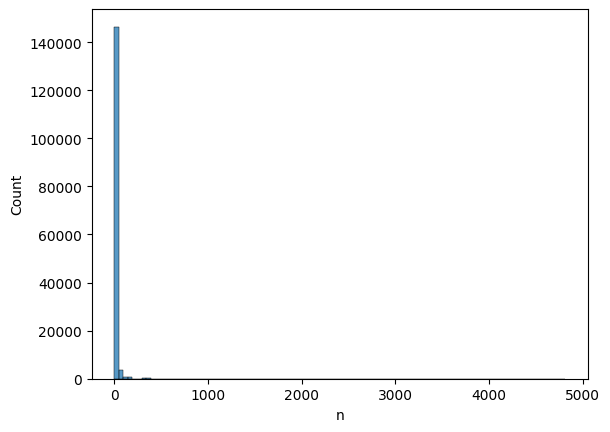

In [115]:
import seaborn as sns

sns.histplot(x=degree_df['n'], bins=100)

In [113]:
node_df.loc[node_df['node_index'] == 180287]

,node_id,node_name,ntype,node_index
180287,773.0:phecode,Pain in limb,PHECODE,180287


In [119]:
degree_df['node_id'] = degree_df['node_id'].astype(int)

In [121]:
degree_df = degree_df.merge(node_df, left_on='node_id', right_on='node_index')

In [218]:
connected_edge_df.groupby('relationship').count()

,index,node_id_x,node_name_x,ntype_x,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
relationship,,,,,,,,,,
atc:atc,8920,8920,8920,8920,8920,8920,8920,8920,8920,8920
atc:cpt,4,4,4,4,4,4,4,4,4,4
atc:icd10cm,4267,4267,4267,4267,4267,4267,4267,4267,4267,4267
atc:icd9cm,3500,3500,3500,3500,3500,3500,3500,3500,3500,3500
atc:lnc,1292,1292,1292,1292,1292,1292,1292,1292,1292,1292
...,...,...,...,...,...,...,...,...,...,...
umls_cui:lnc,15941,15941,15941,15941,15941,15941,15941,15941,15941,15941
umls_cui:phecode,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533
umls_cui:rxnorm,14460,14460,14460,14460,14460,14460,14460,14460,14460,14460


# KG versions

In [2]:
edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

In [ ]:
# NetworkX adj list
edge_df[['node_index_x', 'node_index_y']].to_csv("ClinGraph_adjlist.csv", sep=' ', index=False, header=False)
g = nx.read_adjlist("ClinGraph_adjlist.csv")

In [ ]:
# DGL 
import dgl 
import torch 

print("Assembling graph")
node_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_node_v3_df.csv", sep='\t')
edge_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_edge_v3_df.csv", sep='\t')

u = torch.tensor(edge_df['node_index_x'].tolist())
v = torch.tensor(edge_df['node_index_y'].tolist())

g = dgl.graph((u,v))
graph_feature_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/graph_feature_v3_df.csv")
g.ndata['feat'] = torch.tensor(graph_feature_df.values, dtype=torch.float32)

ntype_list = node_df['ntype'].unique()
ntype_dict = {}
ntype_index_dict = {}
i = 0
for t in ntype_list:
    ntype_dict[t] = i
    ntype_index_dict[i] = t
    i+=1 

ntype_index_dict = {}
ntype_index_dict['ATC'] = 0
ntype_index_dict['CPT'] = 1
ntype_index_dict['ICD9CM'] = 2
ntype_index_dict['ICD10CM'] = 2
ntype_index_dict['LNC'] = 1
ntype_index_dict['PHECODE'] = 2
ntype_index_dict['RXNORM'] = 0
ntype_index_dict['SNOMEDCT_US'] = 3
ntype_index_dict['UMLS_CUI'] = 3

node_df['ntype_index'] = node_df['ntype'].map(ntype_index_dict)
g.ndata['ntype'] = torch.tensor(node_df['ntype_index'].tolist(), dtype=torch.int32)
from dgl.data.utils import save_graphs
save_graphs("harvard_dataverse/ClinGraph_dgl.bin", [g])

Assembling graph


In [ ]:
from torch_geometric.data import Data

edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

# Define edge indices
edge_index = torch.tensor([edge_df['node_index_x'].tolist(),
                           edge_df['node_index_y'].tolist()], dtype=torch.long)

graph_feature_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/graph_feature_v3_df.csv")

# Define node features
x = torch.tensor(graph_feature_df.values, dtype=torch.float)

# Create a Data object
data = Data(x=x, edge_index=edge_index)

# Save the entire dataset
torch.save(data, 'harvard_dataverse/ClinGraph_pyg.pt')

In [39]:
edge_df.head()

,index,node_id_x,node_name_x,ntype_x,relationship,node_id_y,node_name_y,ntype_y,node_index_x,node_index_y,edge_index
0,1,72962:rxnorm,docetaxel,RXNORM,DEFINED,L01CD:atc,"Taxanes, antineoplastic",ATC,51205,48315,0
1,2,3966:rxnorm,ephedrine,RXNORM,DEFINED,R05CA:atc,Expectorants,ATC,50241,45362,1
2,3,3992:rxnorm,epinephrine,RXNORM,DEFINED,N01BB:atc,Amide local anesthetics,ATC,50242,48159,2
3,4,4099:rxnorm,"estrogens, conjugated (USP)",RXNORM,DEFINED,G03FA:atc,"Progestogens and estrogens, fixed combinations",ATC,50252,48248,3
4,5,4451:rxnorm,flucytosine,RXNORM,DEFINED,J02AX:atc,Other antimycotics for systemic use in ATC,ATC,50280,48953,4


# Embedding versions

In [40]:
import pandas as pd
import pickle 
import torch

def to_pickle(df, f):
    with open(f, 'wb') as fname:
        pickle.dump(df, fname)

def open_pickle(f):
    with open(f, 'rb') as file:
        data = pickle.load(file)
    return data

In [ ]:
phekg_node_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_node_v3_df.csv", sep='\t')

phekg_cui_embeds = open_pickle("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_cui.pkl")
phekg_cui_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'UMLS_CUI']
df = pd.DataFrame(phekg_cui_embeds, index=phekg_cui_df['node_index'].tolist())
df.to_csv("ClinVec_umls.csv", header=True, index=True, sep=',')

In [47]:
phekg_atc_embeds = open_pickle("/n/home01/ruthjohnson/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_atc.pkl")
phekg_atc_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ATC']
df = pd.DataFrame(phekg_atc_embeds, index=phekg_atc_df['node_index'].tolist())
df.to_csv("ClinVec_atc.csv", header=True, index=True, sep=',')

In [48]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_phecode.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'PHECODE']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_phecode.csv", header=True, index=True, sep=',')

In [49]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_snomed.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'SNOMEDCT_US']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_snomedct.csv", header=True, index=True, sep=',')

In [50]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_icd10.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ICD10CM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_icd10cm.csv", header=True, index=True, sep=',')

In [51]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_icd9.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'ICD9CM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_icd9cm.csv", header=True, index=True, sep=',')

In [52]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_rxnorm.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'RXNORM']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_rxnorm.csv", header=True, index=True, sep=',')

In [54]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_lnc.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'LNC']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_lnc.csv", header=True, index=True, sep=',')

In [55]:
phekg_phecode_embeds = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/final_embeddings/gnn_embeds_small_ntype_full_neighbor_cpt.pkl")
phekg_phecode_df = phekg_node_df.loc[phekg_node_df['ntype'] == 'CPT']
df = pd.DataFrame(phekg_phecode_embeds, index=phekg_phecode_df['node_index'].tolist())
df.to_csv("ClinVec_cpt.csv", header=True, index=True, sep=',')

In [60]:
import pandas as pd

# load phecode embeddings
df = pd.read_csv("ClinVec_phecode.csv")

# get matrix of embeddings
emb_mat = df.values

# get node metadata
node_df = pd.read_csv("ClinGraph_nodes.csv", sep='\t')
df['node_index'] = df.index
phecode_emb_df = df.merge(node_df, how='inner', on='node_index')

In [61]:
phecode_emb_df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,122,123,124,125,126,127,node_index,node_id,node_name,ntype
0,108490,-8.252774,-10.008340,2.450239,-2.365206,-7.629035,11.505103,0.366181,-4.933194,-9.669165,...,-8.244699,-6.517928,2.705620,-5.787675,6.872317,-8.468920,0,789.0:icd9cm,Abdominal pain,ICD9CM
1,108491,-8.759756,-7.133308,-0.627591,-5.206552,-8.022506,8.743834,-1.098971,-2.765118,-8.495240,...,-8.503339,-2.618777,3.638133,-5.833642,2.361309,-5.447535,1,520.2:icd9cm,Abnormalities of size and form of teeth,ICD9CM
2,108492,-7.579075,-6.282095,-1.794689,-4.666381,-8.040098,7.720970,-3.089917,-3.691666,-5.454268,...,-7.485843,-1.101381,4.932792,-6.409150,0.024862,-2.871532,2,251.5:icd9cm,Abnormality of secretion of gastrin,ICD9CM
3,108493,-7.207140,-4.191913,-4.604074,-4.674320,-5.553472,5.562275,-4.345500,-2.256395,-2.670582,...,-5.768753,2.112556,4.058359,-5.652261,-3.922810,0.382054,3,634:icd9cm,Spontaneous abortion,ICD9CM
4,108494,-8.582227,-6.140819,-1.450412,-5.249937,-8.146950,7.984882,-1.404204,-1.571751,-7.364511,...,-8.569725,-0.165040,4.300578,-5.792841,0.494873,-4.165176,4,632:icd9cm,Missed abortion,ICD9CM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,110278,-3.424452,-2.121988,-4.841920,-4.049212,-2.471359,1.758095,-7.240350,-4.843853,2.086054,...,-1.672188,-0.364733,1.992002,-3.699849,-4.539177,2.655902,1788,013.61:icd9cm,"Tuberculous encephalitis or myelitis, bacterio...",ICD9CM
1789,110279,-6.614455,-9.505219,2.283926,-1.451893,-5.941207,9.677986,-4.883672,-4.014568,-2.128048,...,-7.291325,-1.840473,-0.446444,-1.946195,3.218427,-8.037433,1789,013.62:icd9cm,"Tuberculous encephalitis or myelitis, bacterio...",ICD9CM
1790,110280,-2.991784,-1.437084,-4.994030,-4.623467,-2.881358,1.089833,-6.769373,-5.178181,1.444817,...,-1.420049,-1.236986,2.900282,-4.283151,-4.355249,3.338756,1790,013.63:icd9cm,"Tuberculous encephalitis or myelitis, tubercle...",ICD9CM
1791,110281,-2.098383,-2.825050,-3.688952,-2.618571,-3.607536,2.546577,-7.454947,-7.396249,2.553179,...,-1.089605,-2.311492,4.140357,-5.175703,-3.235469,3.099006,1791,013.64:icd9cm,"Tuberculous encephalitis or myelitis, tubercle...",ICD9CM


# KG summary statistics

In [ ]:
import pandas as pd

new_node_df = pd.read_csv("connected_node_v3_df.csv", sep='\t')
old_node_df = pd.read_csv("/n/home01/ruthjohnson/kg_paper/construct_kg/phekg/new_node_map_df.csv")

In [ ]:
# new node counts
new_node_df.groupby('ntype').count()

,node_id,node_name,node_index
ntype,,,
ATC,5179,5179,5179
CPT,4377,4377,4377
ICD10CM,34842,34842,34842
ICD9CM,10157,10157,10157
LNC,14399,14399,14399
PHECODE,1793,1793,1793
RXNORM,10130,10130,10130
SNOMEDCT_US,29406,29406,29406
UMLS_CUI,42883,42882,42883


In [53]:
new_node_df.loc[(new_node_df['ntype'] == 'ATC') & (new_node_df['node_id'].str.len() < 11)]

,node_id,node_name,ntype,node_index
44846,C03DA:atc,Aldosterone antagonists,ATC,44846
44848,L01A:atc,ALKYLATING AGENTS,ATC,44848
44849,V01A:atc,ALLERGENS,ATC,44849
44890,N02A:atc,OPIOID ANALGESICS,ATC,44890
44892,G03B:atc,ANDROGENS,ATC,44892
...,...,...,...,...
107822,V01:atc,ALLERGENS,ATC,107822
107894,C03:atc,DIURETICS,ATC,107894
108228,N02:atc,ANALGESICS,ATC,108228
108417,A11:atc,VITAMINS,ATC,108417


In [11]:
new_edge_df = pd.read_csv("connected_edge_v3_df.csv", sep='\t')

In [14]:
new_edge_df['etype'] = new_edge_df['ntype_x'] + '_' + new_edge_df['ntype_y']